# Teacher Forcing in RNNs

**Roberto Fierimonte** - 19/02/2018

---

In [1]:
import datetime
import functools
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline 

tfd = tf.contrib.distributions
tfb = tf.contrib.bayesflow

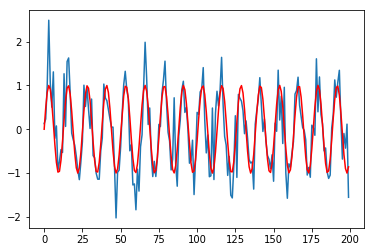

In [2]:
time = np.arange(0, 100, 0.5)
sigma = 0.5
y = np.sin(time)
# y = 0.2 * time + 3 * np.sin(0.5 * time) - 3 * np.cos(1.5 * time)
y_tilde = y[None, :] + sigma * np.random.randn(10, len(time))

plt.plot(y_tilde[0])
plt.plot(y, 'r')
ts = y_tilde[0]

In [3]:
def doublewrap(function):
    """
    A decorator decorator, allowing to use the decorator to be used without
    parentheses if not arguments are provided. All arguments must be optional.
    """
    @functools.wraps(function)
    def decorator(*args, **kwargs):
        if len(args) == 1 and len(kwargs) == 0 and callable(args[0]):
            return function(args[0])
        else:
            return lambda wrapee: function(wrapee, *args, **kwargs)
    return decorator


@doublewrap
def define_scope(function, scope=None, *args, **kwargs):
    """
    A decorator for functions that define TensorFlow operations. The wrapped
    function will only be executed once. Subsequent calls to it will directly
    return the result so that operations are added to the graph only once.
    The operations added by the function live within a tf.variable_scope(). If
    this decorator is used with arguments, they will be forwarded to the
    variable scope. The scope name defaults to the name of the wrapped
    function.
    """
    attribute = '_cache_' + function.__name__
    name = scope or function.__name__
    @property
    @functools.wraps(function)
    def decorator(self):
        if not hasattr(self, attribute):
            with tf.variable_scope(name, *args, **kwargs):
                setattr(self, attribute, function(self))
        return getattr(self, attribute)
    return decorator

# Baseline Model

In [0]:
class LinearCell(tf.contrib.rnn.RNNCell):
    """
    """
    def __init__(self, output_size, state_size, reuse=None):
        super(LinearCell, self).__init__(_reuse=reuse)
        self._output_size = output_size
        self._state_size = state_size
    
    @property
    def state_size(self):
        return self._state_size
    
    @property
    def output_size(self):
        return self._output_size
    
    def call(self, inputs, state):
        state = tf.layers.dense(inputs, self._state_size) + tf.layers.dense(state, self._state_size)
        out = tf.layers.dense(state, self._output_size)
        return out, state

class SimpleSamplingCell(tf.contrib.rnn.RNNCell):
    """
    """
    def __init__(self, cell, output_size, layer, reuse=None):
        super(SimpleSamplingCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._output_size = output_size
        self._layer = layer

    @property
    def state_size(self):
        return (self._cell.state_size, self._output_size)

    @property
    def output_size(self):
        return (self._output_size)
    
    def call(self, inputs, state_and_sample):
        del inputs  # Unused.
        (state, sample) = state_and_sample
        out, state = self._cell(sample, state)
        sample = self._layer(out)
        return sample, (state, sample)
    
class BaselineModel(object):
    """
    """
    def __init__(self, cell_type='GRU', n_hidden=100):
        self._n_hidden = n_hidden
        self._cell_type = cell_type
        if cell_type == 'Linear':
            self._cell = LinearCell(1, self._n_hidden)
            self._sampling_cell = self._cell
        else:
            self._layer = tf.layers.Dense(1)
            if cell_type == 'GRU':
                self._cell = tf.contrib.rnn.GRUBlockCell(self._n_hidden)
            elif cell_type == 'LSTM':
                self._cell = tf.contrib.rnn.LSTMBlockCell(self._n_hidden)
            elif cell_type == 'RNN':
                self._cell = tf.contrib.rnn.BasicRNNCell(self._n_hidden)
            self._sampling_cell = SimpleSamplingCell(self._cell, 1, self._layer)

    def compute_forward(self, data):
        (out, hidden) = tf.nn.dynamic_rnn(self._cell, inputs=data, dtype=tf.float32)
        if self._cell_type != 'Linear':
            out = self._layer(out)
        return out, hidden    
    
    def pred_forward(self, data, last_training_point, last_hidden):
        inputs = tf.concat([last_training_point[:, None], data], 1)        
        (out, _) = tf.nn.dynamic_rnn(self._cell, inputs=inputs, initial_state=last_hidden, dtype=tf.float32)
        if self._cell_type != 'Linear':
            out = self._layer(out)
        return out
    
    def pred_forward_autoregressive(self, last_training_point, last_hidden, future=500):
        sample = last_training_point
        hidden = last_hidden
        samples = []
        
        for _ in range(future):
            (sample, hidden) = self._cell(sample, hidden)
            if self._cell_type != 'Linear':
                sample = self._layer(sample)
            samples.append(sample)
            
        return tf.transpose(tf.stack(samples, 0), [1,0,2])

In [157]:
tf.reset_default_graph()

seq_length = 150; cell_type = 'Linear'; n_hidden = 10
x_ = tf.placeholder(tf.float32, [None, None, 1])
x_test = tf.placeholder(tf.float32, [None, None, 1])

with tf.variable_scope(cell_type + '_' + str(n_hidden), reuse=tf.AUTO_REUSE) as scope:
    model = BaselineModel(cell_type, n_hidden)
    res, hidden = model.compute_forward(x_[:, :-1])
    loss = tf.reduce_mean(tf.reduce_sum(tf.square(res[..., 0] - x_[:, 1:, 0]), 1))/2
    optimise = tf.train.AdamOptimizer(0.001).minimize(loss)
    
    pred_tf = model.pred_forward(x_test, x_[:, -1], hidden)
    pred_ar_tf = model.pred_forward_autoregressive(x_[:, -1], hidden, future=100)

config = tf.ConfigProto(allow_soft_placement=True)
sess = tf.InteractiveSession(config=config) 
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
errors_baseline = []; preds_baseline = []; preds_baseline_ar = []; errors_test_baseline = []

timestamp = datetime.datetime.strftime(datetime.datetime.now(), "%Y-%m-%d_%H:%M")

for i in range(10001):
    batch = ts[None, :seq_length+1]
#     batch = np.stack([ts[i:i+seq_length] for i in np.random.randint(0, 150-seq_length, 10)])    
    error = sess.run(loss, {x_: batch[..., None]})
    sess.run(optimise, {x_: batch[..., None]})
    errors_baseline.append(error)
    
    if i % 1000 == 0:
        test_batch = ts[seq_length+1:]
        test_error = sess.run(loss, {x_: test_batch[None, :, None]})
        errors_test_baseline.append(test_error)
        print('Iteration:', i, 'Training Error:', error, 'Test Error:', test_error)
        pred = sess.run(pred_tf, {x_: ts[None, :seq_length+1, None], x_test: ts[None, seq_length+1:, None]})
        pred_ar = sess.run(pred_ar_tf, {x_: ts[None, :seq_length, None]})
        preds_baseline.append(pred); preds_baseline_ar.append(pred_ar)
        
# save_path = saver.save(sess, "/mnt/workspace/baseline_{}_length_{}_iter_{}.ckpt".format(timestamp, seq_length, i))

Iteration: 0 Training Error: 532596.6 Test Error: 387938.47
Iteration: 1000 Training Error: 794.7384 Test Error: 623.28
Iteration: 2000 Training Error: 217.19664 Test Error: 535.2322
Iteration: 3000 Training Error: 175.2297 Test Error: 566.4844
Iteration: 4000 Training Error: 171.34695 Test Error: 193.30357
Iteration: 5000 Training Error: 152.93503 Test Error: 188.87491
Iteration: 6000 Training Error: 137.89296 Test Error: 203.2348
Iteration: 7000 Training Error: 123.22671 Test Error: 240.41193
Iteration: 8000 Training Error: 97.29881 Test Error: 692.8097
Iteration: 9000 Training Error: 92.56614 Test Error: 1045.4834
Iteration: 10000 Training Error: 92.92415 Test Error: 1252.7979


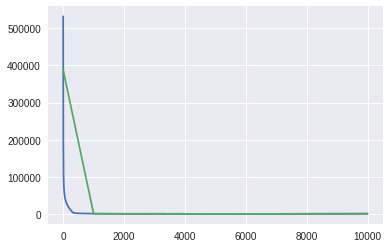

In [161]:
plt.plot(errors_baseline)
plt.plot(range(0, 10001, 1000), errors_test_baseline)

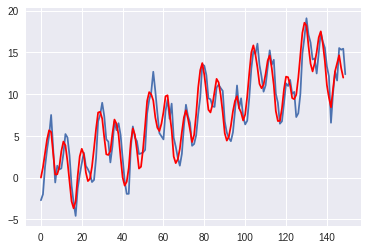

In [162]:
fit = sess.run(res, {x_: ts[None, :150, None]})
plt.plot(ts[None, :150].T)
plt.plot(fit[..., 0].T, 'r')

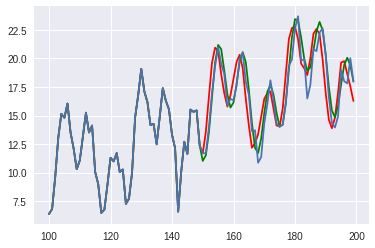

In [163]:
plt.plot(range(100, 200), np.concatenate([ts[None, 100:150, None], pred], 1)[0], 'r')
plt.plot(range(100, 200), np.concatenate([ts[None, 100:150, None], pred_ar[:, :50]], 1)[0], 'g-')
plt.plot(range(100, 200), ts[None, 100:200].T)

# Our Model

In [4]:
class LinearMarkovianCellWithState(tf.contrib.rnn.RNNCell):
    """
    """
    def __init__(self, event_size, state_size, reuse=None):
        super(LinearMarkovianCellWithState, self).__init__(_reuse=reuse)
        self._state_size = state_size
        self._event_size = event_size
        self._A = tf.get_variable('A', shape=(state_size, state_size), dtype=tf.float32)
        self._B = tf.get_variable('B', shape=(event_size, state_size), dtype=tf.float32)
        self._c = tf.get_variable('c', shape=(event_size,), dtype=tf.float32)
        self._D = tf.get_variable('D', shape=(state_size, event_size), dtype=tf.float32)
        self._e = tf.get_variable('e', shape=(event_size,), dtype=tf.float32)
        
    @property
    def state_size(self):
        return self._state_size

    @property
    def output_size(self):
        return self._event_size

    def call(self, inputs, state):
        state = tf.matmul(state, self._A)  + tf.matmul(inputs, self._B) + self._c
        mean = tf.matmul(state, self._D) + self._e
        return mean, state
        
class RobustARGenerator(object):
    """
    Model to test
    """
    def __init__(self, data, n_hidden=100, n_samples=200, seq_length=1000, batch_size=1):
        self._data = data
        self._n_hidden = n_hidden
        self._batch_size = batch_size
        self._n_samples = n_samples
        self._seq_length = seq_length
        self._cell = LinearMarkovianCellWithState(1, self._n_hidden)
        
        self._optimiser = tf.train.AdamOptimizer(0.001)
        self._gen_stddev = tf.nn.softplus(tf.get_variable('generative_std', shape=(), 
                                           initializer=tf.constant_initializer(1)))
#         self._gen_stddev = tf.get_variable('generative_std', shape=(), trainable=False, 
#                                            initializer=tf.constant_initializer(0.5))
        self.make_posterior
        self.compute_elbo_david
        self.E_step
        self.M_step
    
    @define_scope
    def make_posterior(self):
#         means = tf.Variable(initial_value=ts[:seq_length][None, ...], name='post_means', dtype=tf.float32)
        means = tf.Variable(initial_value=data[:1], name='post_means', dtype=tf.float32)
        self._post_stddev = tf.nn.softplus(tf.get_variable(shape=(), initializer=tf.constant_initializer(1), 
                                                           name='post_std'))
        return tfd.Independent(tfd.MultivariateNormalDiag(means, scale_identity_multiplier=self._post_stddev))
        
    @define_scope
    def make_transitional(self):
#         h0 = tf.Variable(tf.zeros((10 * self._n_samples, self._n_hidden)), name='h0', dtype=tf.float32)
#         inputs = tf.concat([tf.Variable(tf.zeros((10 * self._n_samples, 1, 1)), trainable=False, 
#                                         name='y0', dtype=tf.float32), 
#                             self._code[:, :-1]], 1)
        inputs = tf.concat([tf.zeros((self._batch_size * self._n_samples, 1, 1)), self._code[:, :-1]], 1)
        means, _ = tf.nn.dynamic_rnn(self._cell, inputs=inputs, dtype=tf.float32)
        return means
    
    @define_scope
    def compute_elbo_david(self):      
        posterior = self.make_posterior
        print(posterior.batch_shape, posterior.event_shape)
        code = tf.transpose(posterior.sample((self._batch_size * self._n_samples)), [0, 2, 1])
        print(code.shape)
        self._code = tf.reshape(code, [-1, self._seq_length, 1])
        print(self._code.shape)
        
        entropy = self._seq_length * tf.log(tf.square(self._post_stddev))
        means = self.make_transitional
        print(means.shape)
        exponent_trans = tf.square(self._code[..., 0] - means[..., 0])
        print(exponent_trans.shape)
        kl = - entropy + self._seq_length * tf.log(tf.reduce_mean(tf.reduce_sum(exponent_trans, -1)))
        
        exp1 = tf.reduce_mean(tf.reduce_sum(tf.square(posterior.mean() - self._data[:self._batch_size, ..., 0]), -1))
        num  = self._seq_length * tf.square(self._post_stddev) + exp1
        
#         reconstruction = (- self._seq_length * exp1/num - tf.square(self._seq_length * self._post_stddev)/num
#                           - self._seq_length * tf.log(num/self._seq_length))
        exponent_gen = exp1/tf.square(self._gen_stddev)
        reconstruction = (- exponent_gen - self._seq_length * tf.log(tf.square(self._gen_stddev))
                          - self._seq_length * tf.square(self._post_stddev/self._gen_stddev))
        
        return reconstruction - kl, kl, reconstruction, entropy
    
    @define_scope
    def E_step(self):
        post_var = [v for v in tf.trainable_variables() if v.name.startswith('make_posterior/')]
        return self._optimiser.minimize(-self.compute_elbo_david[0], var_list=post_var)
    
    @define_scope
    def M_step(self):
        non_post_var = [v for v in tf.trainable_variables() if not v.name.startswith('make_posterior/')]
        return self._optimiser.minimize(-self.compute_elbo_david[0], var_list=non_post_var)
    
    @define_scope
    def trans_std(self):
        posterior = self.make_posterior
        code = tf.transpose(posterior.sample((self._batch_size * self._n_samples)), [0, 2, 1])
        self._code = tf.reshape(code, [-1, self._seq_length, 1])
        means = self.make_transitional
        
        return tf.sqrt(tf.reduce_mean(
            tf.reduce_sum(tf.square(self._code[..., 0] - means[..., 0]), -1))/self._seq_length)
    
    @define_scope
    def gen_std(self):
#         posterior = self.make_posterior
#         exp1 = tf.reduce_mean(tf.reduce_sum(tf.square(posterior.mean() - self._data[:self._batch_size, ..., 0]), -1))
#         num  = self._seq_length * tf.square(self._post_stddev) + exp1
#         return tf.sqrt(num/self._seq_length)
    
        return self._gen_stddev    

In [9]:
tf.reset_default_graph()

seq_length = 70; n_samples = 100; batch_size = 10;
data = np.tile(y_tilde[:batch_size, :seq_length], (n_samples, 1))
x_ = tf.placeholder(tf.float32, [batch_size, seq_length, 1])

gen_model = RobustARGenerator(x_, n_hidden=2, n_samples=n_samples, seq_length=seq_length, batch_size=batch_size)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

elbos = []; kls = []; llks = []; test_elbos = []; preds = []; preds_greedy = []
means = []; stds = []; gen_stddevs = []; post_stddevs = []; post_samples = []; post_means = []

for i in range(25001):
    batch = data[:batch_size]
#     batch = ts[:seq_length][None, ...]
    elbo, kl, llk, entropy = sess.run(gen_model.compute_elbo_david, {x_: batch[..., None]})
    elbos.append(elbo); kls.append(kl); llks.append(llk)
    post_means.append(sess.run(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'make_posterior/post_means:0'))[0])
    post_stddevs.append(sess.run(gen_model._post_stddev))
    m = sess.run(gen_model.make_transitional, {x_: batch[..., None]})
    s = sess.run(gen_model.trans_std, {x_: batch[..., None]})
    means.append(m); stds.append(s); gen_stddevs.append(sess.run(gen_model.gen_std, {x_: batch[..., None]}))
    latents = sess.run(gen_model._code, {x_: batch[..., None]})
    post_samples.append(latents)
    
    if i % 100 == 0:
        print('Iteration:', i, 'ELBO:', elbo, 'KL:', kl, 'Reconstruction:', llk, 'Entropy:', entropy)
    
    sess.run(gen_model.E_step, {x_: batch[..., None]})
    sess.run(gen_model.M_step, {x_: batch[..., None]})

() (1, 70)
(1000, 70, 1)
(1000, 70, 1)
(1000, 70, 1)
(1000, 70)
Iteration: 0 ELBO: -551.228 KL: 427.306 Reconstruction: -123.921 Entropy: 38.1519
Iteration: 100 ELBO: -517.811 KL: 403.132 Reconstruction: -114.68 Entropy: 28.539
Iteration: 200 ELBO: -488.551 KL: 386.515 Reconstruction: -102.036 Entropy: 13.2688
Iteration: 300 ELBO: -461.807 KL: 372.156 Reconstruction: -89.6518 Entropy: -3.40782
Iteration: 400 ELBO: -436.95 KL: 358.513 Reconstruction: -78.4367 Entropy: -20.6683
Iteration: 500 ELBO: -412.941 KL: 344.826 Reconstruction: -68.1145 Entropy: -38.9359
Iteration: 600 ELBO: -391.005 KL: 333.303 Reconstruction: -57.7019 Entropy: -58.9825
Iteration: 700 ELBO: -370.985 KL: 325.04 Reconstruction: -45.9458 Entropy: -80.8472
Iteration: 800 ELBO: -359.083 KL: 324.544 Reconstruction: -34.5384 Entropy: -101.398
Iteration: 900 ELBO: -354.126 KL: 327.56 Reconstruction: -26.5654 Entropy: -117.483
Iteration: 1000 ELBO: -351.522 KL: 329.985 Reconstruction: -21.5379 Entropy: -128.846
Iteration:

Iteration: 9600 ELBO: -272.301 KL: 298.12 Reconstruction: 25.8191 Entropy: -458.393
Iteration: 9700 ELBO: -271.665 KL: 297.473 Reconstruction: 25.8074 Entropy: -457.666
Iteration: 9800 ELBO: -272.544 KL: 298.369 Reconstruction: 25.8242 Entropy: -458.433
Iteration: 9900 ELBO: -271.527 KL: 297.357 Reconstruction: 25.8303 Entropy: -459.812
Iteration: 10000 ELBO: -270.763 KL: 296.586 Reconstruction: 25.8229 Entropy: -459.566
Iteration: 10100 ELBO: -271.4 KL: 297.229 Reconstruction: 25.8285 Entropy: -458.368
Iteration: 10200 ELBO: -272.885 KL: 298.714 Reconstruction: 25.8294 Entropy: -459.467
Iteration: 10300 ELBO: -271.269 KL: 297.099 Reconstruction: 25.8298 Entropy: -459.371
Iteration: 10400 ELBO: -272.823 KL: 298.651 Reconstruction: 25.8274 Entropy: -460.053
Iteration: 10500 ELBO: -271.72 KL: 297.542 Reconstruction: 25.8215 Entropy: -458.07
Iteration: 10600 ELBO: -272.584 KL: 298.43 Reconstruction: 25.8463 Entropy: -460.418
Iteration: 10700 ELBO: -271.532 KL: 297.375 Reconstruction: 25.8

Iteration: 19200 ELBO: -273.118 KL: 298.962 Reconstruction: 25.8436 Entropy: -460.296
Iteration: 19300 ELBO: -272.783 KL: 298.625 Reconstruction: 25.8421 Entropy: -458.375
Iteration: 19400 ELBO: -272.427 KL: 298.283 Reconstruction: 25.8556 Entropy: -460.201
Iteration: 19500 ELBO: -271.756 KL: 297.594 Reconstruction: 25.8372 Entropy: -460.267
Iteration: 19600 ELBO: -271.425 KL: 297.268 Reconstruction: 25.8427 Entropy: -457.866
Iteration: 19700 ELBO: -271.462 KL: 297.312 Reconstruction: 25.8498 Entropy: -460.841
Iteration: 19800 ELBO: -272.434 KL: 298.274 Reconstruction: 25.8402 Entropy: -458.629
Iteration: 19900 ELBO: -273.115 KL: 298.958 Reconstruction: 25.8436 Entropy: -459.655


KeyboardInterrupt: 

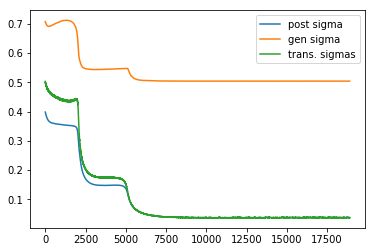

In [10]:
plt.plot(np.squeeze(np.array(post_stddevs))[1000:], label='post sigma')
plt.plot(gen_stddevs[1000:], label='gen sigma')
plt.plot([np.mean(s) for s in stds][1000:], label='trans. sigmas')
plt.legend();

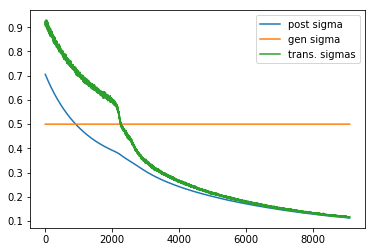

In [58]:
plt.plot(np.squeeze(np.array(post_stddevs))[1000:], label='post sigma')
plt.plot(gen_stddevs[1000:], label='gen sigma')
plt.plot([np.mean(s) for s in stds][1000:], label='trans. sigmas')
plt.legend();

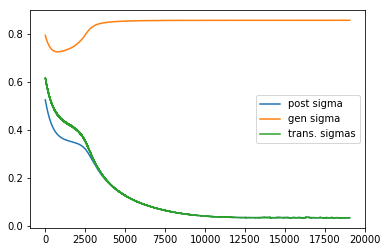

In [6]:
plt.plot(np.squeeze(np.array(post_stddevs))[1000:], label='post sigma')
plt.plot(gen_stddevs[1000:], label='gen sigma')
plt.plot([np.mean(s) for s in stds][1000:], label='trans. sigmas')
plt.legend();

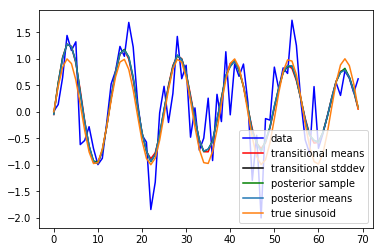

In [57]:
# plt.plot(ts[:70], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
# plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(np.stack(latents, 0), 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
# plt.plot(y[:70], label='true sinusoid')
plt.legend();

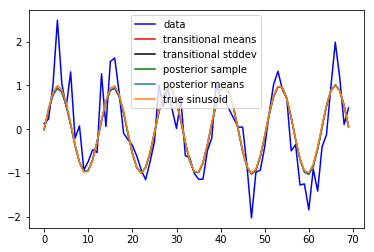

In [13]:
plt.plot(ts[:70], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(np.stack(latents, 0), 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
plt.plot(y[:70], label='true sinusoid')
plt.legend();

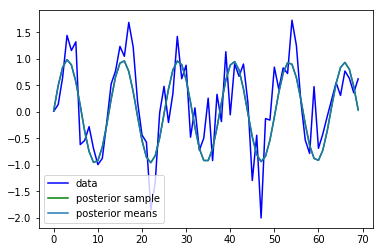

In [27]:
plt.plot(ts[:70], 'b', label='data')
plt.plot(np.mean(means[-1], 0), 'r-', label='transitional means')
plt.plot(stds[-1], 'k', label='transitional stddev')
plt.plot(np.mean(np.stack(latents, 0), 0), 'g', label='posterior sample')
plt.plot(np.mean(sess.run(gen_model.make_posterior.mean() , {x_: batch[..., None]}), 0), label='posterior means')
plt.plot(y[:70], label='true sinusoid')
plt.legend();